## Fisher Matrix for 2D angular clustering - Including cross-correlations

In the present notebook, we model the Angular power spectrum of Galaxies, we calculate the Fisher matrix considering as free parameters the redshift matter density $\Omega_{m,0}$ and the power spectrum normalization $\sigma_8$ and plot the confidence contours.

## Modeling the Angular power spectrum 

In the Limber approximation (valid for small angles, or $\ell > \sim 20$), we model the angular auto-correlation power spectrum for galaxy clustering as:

\begin{equation}
C_\ell^{ii} = \int \, dz \, \frac{W_i^2(z)b_i^2(z) H(z)/c}{\chi^2(z) } P_m\left(z; \frac{\ell + 1/2}{\chi(z)}\right)
\end{equation}

Although we will not use it here, the cross-correlation spectrum is similarly given by:

\begin{equation}
C_\ell^{ij} = \int \, dz \, \frac{W_i(z) W_j(z) b_i(z)b_j(z) H(z)/c}{\chi^2(z)} P_m\left(z; \frac{\ell + 1/2}{\chi(z)}\right).
\end{equation}

$W_i(z)$ is the radial selection function that encodes the probability of a galaxy to be included in a given bin $i$.
This is the product of the overall (normalized) redshift distribution function of objects $dn/dz$ times a selection function $F_i(z)$ chosen appropriately for each redshift bin:

\begin{equation}
W_i(z) = \frac{\frac{dn}{dz}F_i(z)}{\int_0^\infty \frac{dn}{dz}F_i(z) \,dz}
\end{equation}

For a spectroscopic survey $F_i(z)$ is a top-hat function with limits the limits of each bin. For gaussian photometric uncertainties, the window function becomes:

\begin{equation}
F_i(z) = \frac{1}{2}\left[\mbox{erf}\left(\frac{z - z_{min,i}}{\sqrt{2}\sigma_z} \right) - \mbox{erf}\left(\frac{z - z_{max,i}}{\sqrt{2}\sigma_z} \right)\right] ,
\end{equation}

$z_{min/max,i}$ being the limits of the bin $i$.

The normalized overall redshift distribution can be described by: 

\begin{equation}
\frac{dn}{dz}(z) = \frac{\beta}{z_0^{1+ \alpha}\Gamma\left[\frac{1+\alpha}{\beta}\right]}z^\alpha \exp\left[- \left(\frac{z}{z_0}\right)^\beta \right].
\end{equation}

With $\alpha$ and $\beta$ parameters that describe the shape of the distribution and $z_0$ is related to the median redshift (which means, it has to do with the depth of the survey). Here we take the parameters for DES: $\alpha = 1.25$, $\beta = 2.29$, $z_0 = 0.88$:

\begin{equation}
\frac{dn}{dz}(z) \cong \frac{2.27}{z_0}\left(\frac{z}{z_0} \right)^{1.25}\exp \left[- \left(\frac{z}{z_0} \right)^{2.29} \right]
\end{equation}




If the total angular number density of galaxies is 
$\bar{n}^{\,tot}$, the angular number density in a bin $i$ is:

\begin{equation}
\bar{n}^i = \bar{n}^{\, tot}\times \left[\int_0^\infty \frac{dn}{dz}F_i(z) \,dz \right].
\end{equation}

One can check that $\sum_i\bar{n}^i  = \bar{n}^{tot}$.
Let's describe now the other quantities that appear in eqs (1-2).

$b^{i}(z)$ is the galaxy bias in redshift bin $i$. This can be either constant in each bin, or we can assume a form, like $b(z) = b_0/D(z)$, $D(z)$ being the growth factor. In the simple exploration this will be our fiducial model, with $b_0$ free to vary (but if otherwise stated equal to $1.0$).

$\chi(z)$ is the comoving distance, defined as: 

$$
\chi(z) = \int_0^z \, \frac{c}{H(z')}\, dz',
$$

$H(z)$ the Hubble parameter; finally $P_m(z; k)$ is the matter power spectrum at redshift $z$. In linear theory $P_m(z;k) = D^2(z) P_{m,0}(k)$, $P_{m,0}(k)$ being the present day linear power spectrum.

## Fisher Matrix calculation

### Including cross-correlation

In that case the Fisher matrix is: 

\begin{equation}
F_{\mu \nu} = \frac{f_{sky}}{2} \sum_{\ell} (2\ell + 1)\mbox{Tr}\left(\mathbf{\hat{C}}_\ell^{-1} \mathbf{\hat{C}}_{\ell,\mu} \mathbf{\hat{C}}_\ell^{-1} \mathbf{\hat{C}}_{\ell,\nu} \right)
\end{equation}

with $\mathbf{\hat{C}}_\ell$ being the matrix with elements $\hat{C}_\ell^{ij} = {C}_\ell^{ij} + \delta_{ij}/\bar{n}^i$.




In [21]:
# Importing stuff
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from scipy.special import erf
from colossus.cosmology import cosmology
import pylab as pl
from scipy import interpolate 
from code.plot_utils import plot_pretty
from scipy.interpolate import UnivariateSpline
%matplotlib inline
%pylab inline
#=====================================================
#=====================================================
import camb
from camb import model, initialpower

Populating the interactive namespace from numpy and matplotlib


In [22]:
# Function that calculates and returns window function W(z) for clustering 

def W_z_clust(z, dz, z_i, z_f, sig_z, b_0, z_0 ):
    """
    Function that calculates the window function for 2D galaxy clustering
    -----------------
    Inputs:
    z: array of redshifts where we are going to calculate the window function
    dz: array of dz's - useful for the integral
    z_i : lower redshift limit of the bin
    z_f : upper redshift limit of the bin
    sig_z : photometric error
    b_0 : present day bias
    z_0 : parameter related to the mean redshift of the sample
    ---------------
    Returns:
    The window function and its integral over all redshifts for a given bin with given limits
    
    """
    # Overall redshift distribution - DES like
    dNdz = (2.27*(z**1.25)/(z_0**2.25))*np.exp(-(z/z_0)**2.29)
    
    # Photometric window function
    x_min = (z - z_i)/((1.0+z)*sig_z*np.sqrt(2.0))
    x_max = (z - z_f)/((1.0+z)*sig_z*np.sqrt(2.0))
    F_z = 0.5*(erf(x_min) - erf(x_max))
    
    # Normalization
    norm_const = np.dot(dz, dNdz*F_z)
    
    #bias model
    bias = b_0*np.sqrt(1.0 + z)
    
    # Window function 
    
    W_z_bin = bias*dNdz*F_z/norm_const
    
    return W_z_bin, norm_const
    

In [23]:
# Function that calculates C_l,ij

def C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, Omega_m_var , sig_8_var , b_0 , sig_z , z_0):
    """
    Function that calculates the C_l between two bins 
    -----------------
    Inputs:
    z_i_1 : Lower limit of the first bin
    z_f_1 : Upper limit of the first bin
    z_i_2 : Lower limit of the second bin
    z_f_2 : Upper limit of the second bin
    Omega_m_var: Omega matter - can change
    sig_8_var : Sigma_8 parameter - can change
    sig_z : photo-z error
    b_0: present day bias
    z_0 : paramerer related to the mean redshift of the sample
    ---------------
    Returns:
    ls and C_l betwenn two bins, i and j. It is the auto spectrum if i=j
    """
    # Constant
    h = 0.675
    c = 2.99792e+5
    
    #======================================
    #====================================================================================
    #====================================================================================
    # Setting up cosmology
    
    cosmo = camb.CAMBparams()
    cosmo.set_cosmology(H0=67.5, ombh2=0.049*(h**2.0), omch2=(Omega_m_var - 0.049)*(h**2.0), mnu=0.06, omk=0, tau=0.06)
    cosmo.InitPower.set_params(As=2.0e-9, ns=0.96)
    results = camb.get_results(cosmo)
    cosmo.set_matter_power(redshifts=[0.0], kmax=10.0)
    cambres= camb.get_transfer_functions(cosmo)
    cosmo.NonLinear = model.NonLinear_both
    kh, z, pk = cambres.get_matter_power_spectrum(minkh=1e-3, maxkh=0.1, npoints = 10)
    sigma_8_temp = cambres.get_sigma8()
    As_new  = ((sig_8_var/sigma_8_temp)**2.0)*(2.0e-9)
    cosmo.InitPower.set_params(As=As_new, ns=0.96)
    cambres = camb.get_results(cosmo)
    backres = camb.get_background(cosmo)
    #====================================================================================
    #====================================================================================
    #Redshift range for calculations and integration
    
    nz = 1000 #number of steps to use for the radial/redshift integration
    kmax=10.0  #kmax to use

    zarray = np.linspace(0,4.0,nz)
    dzarray = (zarray[2:]-zarray[:-2])/2.0
    zarray = zarray[1:-1]
    
    
    
    #====================================================================================
    #====================================================================================
    #Get the power spectrum interpolator
    
    PK = camb.get_matter_power_interpolator(cosmo, nonlinear=True, 
        hubble_units=True, k_hunit=True, kmax=kmax, zmin = 0.0, zmax=zarray[-1]) 

    #====================================================================================
    #====================================================================================
    #Take two window functions
    
    W_1 = W_z_clust(zarray, dzarray, z_i_1, z_f_1, sig_z, b_0, z_0 )[0]
    W_2 = W_z_clust(zarray, dzarray, z_i_2, z_f_2, sig_z, b_0, z_0 )[0]
    
    #====================================================================================
    #====================================================================================
    #Calculate Hubble parameter and comoving distance
    
    H_z = h*backres.hubble_parameter(zarray)/c #Hubble parameter in 1/Mpc h^{-1}
    
    # Get comoving distance - in Mpc/h
    chis = backres.comoving_radial_distance(zarray)/h
    
    #========================================================
    # Get the full prefactor of the integral
    prefact = W_1*W_2*H_z/(chis**2.0)
    #====================================================================================
    
    #===================================================================================
    #===================================================================================
    #Do integral over z
    ls = np.arange(10,4000, dtype=np.float64)
    c_ell=np.zeros(ls.shape)
    w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
    for i, l in enumerate(ls):
        k=(l+0.5)/chis
        w[:]=1
        w[k<1e-4]=0
        w[k>=kmax]=0
        c_ell[i] = np.dot(dzarray, w*PK.P(zarray, k, grid=False)*prefact)
    
    #===================================================================================
    # Retrurn the array of C_ell
    
    return ls, c_ell

#===================================================================================
# Here are the derivatives with respect to matter density and sigma_8
#===================================================================================

def matter_der_C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, Omega_m , sig_8, b_0 , sig_z , z_0):
    """
    Function that calculates the derivative of C_l with respect to matter between two bins 
    -----------------
    Inputs:
    z_i_1 : Lower limit of the first bin
    z_f_1 : Upper limit of the first bin
    z_i_2 : Lower limit of the second bin
    z_f_2 : Upper limit of the second bin
    Omega_m: Omega matter
    sig_8: Sigma_8 parameter
    sig_z : photo-z error
    b_0: present day bias
    z_0 : paramerer related to the mean redshift of the sample
    ---------------
    Returns:
    derivative w/r to matter of C_l betwenn two bins, i and j
    """
    alpha = Omega_m/10.0
    
    C_mat_1 = C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, Omega_m+alpha , sig_8 , b_0 , sig_z , z_0)[1]
    C_mat_2 = C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, Omega_m-alpha , sig_8 , b_0 , sig_z , z_0)[1]
    
    mat_der = (C_mat_1 - C_mat_2)/(2.0*alpha)
    return mat_der
    
    
    
#===================================================================================
    
def sigma_der_C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, Omega_m , sig_8, b_0 , sig_z , z_0):
    """
    Function that calculates the derivative of C_l with respect to sigma_8 between two bins 
    -----------------
    Inputs:
    z_i_1 : Lower limit of the first bin
    z_f_1 : Upper limit of the first bin
    z_i_2 : Lower limit of the second bin
    z_f_2 : Upper limit of the second bin
    Omega_m: Omega matter
    sig_8: Sigma_8 parameter
    sig_z : photo-z error
    b_0: present day bias
    z_0 : paramerer related to the mean redshift of the sample
    ---------------
    Returns:
    derivative w/r to matter of C_l betwenn two bins, i and j
    """
    
    alpha = sig_8/10.0
    
    C_sig_1 = C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, Omega_m, sig_8+alpha , b_0 , sig_z , z_0)[1]
    C_sig_2 = C_l_ij(z_i_1,z_f_1,z_i_2,z_f_2, Omega_m , sig_8-alpha , b_0 , sig_z , z_0)[1]
    
    sig_der = (C_sig_1 - C_sig_2)/(2.0*alpha)
    return sig_der
    

In [24]:
def Fisher_calculator(z_init, z_end, N_bins, f_sky, b_0, sig_z, n_tot, z_0):
    """
    Calculates the Fisher Matrix for a number of bins:
    --------------------------------------------------
    Inputs:
    z_i = lower redshift limit of the distribution
    z_f = upper redshift limit of the distribution
    N_bins = number of bins
    f_sky = fraction of the sky of the survey
    sig_z = redshift error
    n_tot = number density of galaxies in gal/arcmin^2
    z_0 = mean redshift of the distribution
    
    -------------------------------------------------
    Returns:
    The full fisher matrix including cross-correlations
    """
    #==============================================================================
    #Cosmological parameters 
    Omega_m = 0.31
    sigma_8 = 0.81
    h = 0.675
    
    # Set cosmology - for later calculations
    cosmo = camb.CAMBparams()
    cosmo.set_cosmology(H0=67.5, ombh2=0.049*(h**2.0), omch2=(Omega_m - 0.049)*(h**2.0), mnu=0.06, omk=0, tau=0.06)
    backres = camb.get_background(cosmo)
    #==============================================================================
    #arcmins^2 to steradians converter
    #Converts the total number density of galaxies in gal/arcmin^2 to gal/steradian

    arcmin_to_ster = 8.4616e-8
    n_tot_ster = n_tot/arcmin_to_ster #Total number density in galaxies/steradian
    #==================================================================
    #=============================================================
    #Redshift range for calculations and integration
    nz = 1000 #number of steps to use for the radial/redshift integration

    zarray = np.linspace(0,4.0,nz)
    dzarray = (zarray[2:]-zarray[:-2])/2.0
    zarray = zarray[1:-1]
    #==================================================================
    #In this module, find the redshift limits of the bins
    
    delta_z = (z_end -z_init)/N_bins # Width of each bin
    
    z_lims = np.zeros(N_bins+1) #An empty array that will contain the upper and lower limits of the bins
                                #The number of limits is equals the number of bins plus one
    
    # Now populate the array of the redshift limits
    for i in range (0,N_bins+1):
        z_lims[i] = z_init + i*delta_z
    
    #===================================================================
    #===================================================================
    # Now we will create 3D matrices where we are going to store C_l^{ij}, C_l,omega_m^{ij}, C_l,sig_8^{ij}
    
    #Initialize matrices 
    l_size = 3990   #Size in \ell - this can change
    
    
    C_l_matr = np.zeros([N_bins,N_bins,l_size])  #Contains C_ell's
    C_l_omeg = np.zeros([N_bins,N_bins,l_size])  #Contains the derivatives of C_ell's with respect to matter density
    C_l_sig  = np.zeros([N_bins,N_bins,l_size])  #Contains the derivatives of C_ell's with respect to sig_8 
    
    #Now let's populate them - run in all combinations of i, j (the different possible bins)
    #But remember that the matrices are symmetric 
    
    for i in range(0,N_bins):
        for j in range(i,N_bins):
            # Now we have to calculate the limits of the two bins
            #Limits of the first -i- bin
            z_init_i = z_lims[i]
            z_final_i = z_lims[i+1]
            #Limits of the second -j-bin
            z_init_j = z_lims[j]
            z_final_j = z_lims[j+1]
            #======================================================
            if (i==j):
                #Calculate the poisson noise - number of galaxies/steradian in the diagonal 
                n_bin = n_tot_ster*W_z_clust(zarray, dzarray, z_init_i, z_final_i, sig_z, b_0, z_0 )[1]
                C_l_matr[i,i,:] = C_l_ij(z_init_i,z_final_i,z_init_i,z_final_i, Omega_m , sigma_8 , b_0 , sig_z , z_0)[1]+1.0/n_bin
                C_l_omeg[i,i,:] = matter_der_C_l_ij(z_init_i,z_final_i,z_init_i,z_final_i, Omega_m , sigma_8, b_0 , sig_z , z_0)
                C_l_sig[i,i,:] = sigma_der_C_l_ij(z_init_i,z_final_i,z_init_i,z_final_i, Omega_m , sigma_8, b_0 , sig_z , z_0)
            else:
                C_l_matr[i,j,:] = C_l_matr[j,i,:] = C_l_ij(z_init_i,z_final_i,z_init_j,z_final_j, Omega_m , sigma_8, b_0, sig_z, z_0)[1]
                C_l_omeg[i,j,:] = C_l_omeg[j,i,:] = matter_der_C_l_ij(z_init_i,z_final_i,z_init_j,z_final_j, Omega_m , sigma_8, b_0 , sig_z , z_0)
                C_l_sig[i,j,:] = C_l_sig[j,i,:] = sigma_der_C_l_ij(z_init_i,z_final_i,z_init_j,z_final_j, Omega_m , sigma_8, b_0 , sig_z , z_0)
     
    #==============================================================================================
    #==============================================================================================
    #Create array of ells
    ls = np.arange(10,4000, dtype=np.float64)
    
    #Create array of the l_max for each bin
    
    k_cutoff = 0.2     #Cutoff scale in h Mpc^{-1}
    # Empty array that will contain the l_max of each bin 
    l_max = np.zeros(N_bins+1)   
    #Populate now
    for i in range(0,N_bins+1):
        if (i>0):
            z_low = z_lims[i-1]      #Lower redshift limit of the bin
            z_up = z_lims[i]         #Upper redshift limit of the bin
            z_m = 0.5*(z_low + z_up)  #The mean redshift limit of the bin
            chi_m = backres.comoving_radial_distance(z_m)/h   # comoving distance corresponding to the mean redshift of the bin 
            l_max[i] = int(round(k_cutoff*chi_m))
        else:
            l_max[i] = 9
    #==============================================================================================
    #==============================================================================================
    
    #Now we are ready to calculate the elements of the Fisher matrix
    Fish = np.zeros([2,2]) #initialize
    
    # 0 = matter, 1 = sigma_8
    
    for i in range(0, N_bins):
        low_ell = int(l_max[i]) - 9          #lower \ell_limit
        upper_ell = int(l_max[i+1]) - 9       #upper \ell_limit
        #------------------------------------------------------
        #Define the parts of the three matrices in for the bins into consideration
        ls_loc = ls[low_ell:upper_ell]
        C_l_loc = C_l_matr[i:,i:,low_ell:upper_ell]
        C_l_om_loc = C_l_omeg[i:,i:,low_ell:upper_ell]
        C_l_sig_loc = C_l_sig[i:,i:,low_ell:upper_ell]
        #------------------------------------------------------
        #Calculate the inverse of C_l_loc
    
        C_l_inv_loc = np.zeros_like(C_l_loc)
        for k in range(0, np.size(ls_loc)):
            C_l_inv_loc[:,:,k] = np.linalg.inv(C_l_loc[:,:,k])
    
        #-------------------------------------------------------
        #------------------------------------------------------
        #Now we have everything - we can calculate Fisher elements
        
        Fish[0,0] += sum((2.0*ls_loc+1.0)*np.trace(C_l_inv_loc*C_l_om_loc*C_l_inv_loc*C_l_om_loc))
        Fish[1,1] += sum((2.0*ls_loc+1.0)*np.trace(C_l_inv_loc*C_l_sig_loc*C_l_inv_loc*C_l_sig_loc))
        Fish[0,1] += sum((2.0*ls_loc+1.0)*np.trace(C_l_inv_loc*C_l_om_loc*C_l_inv_loc*C_l_sig_loc))
        
        
    Fish[1,0] = Fish[0,1]
    Fish = (0.5*f_sky)*Fish
    
    return Fish


In [25]:
z_init= 0.05
z_end= 1.5
N_bins= 8
f_sky=0.12
b_0=1.0
sig_z=0.1
n_tot= 12.0
z_0 = 0.88

Fisher = Fisher_calculator(z_init, z_end, N_bins, f_sky, b_0, sig_z, n_tot, z_0)

In [26]:
import numpy as np
import math
import sys
import os
import IPython

#=================================================================================

cosmicfish_pylib_path = '/Users/Dimitris/Desktop/2D_clustering/CosmicFish/python'
sys.path.insert(0, os.path.normpath(cosmicfish_pylib_path))

#================================================================================
import cosmicfish_pylib.utilities            as fu
import cosmicfish_pylib.colors               as fc
import cosmicfish_pylib.fisher_matrix        as fm
import cosmicfish_pylib.fisher_derived       as fd
import cosmicfish_pylib.fisher_operations    as fo
import cosmicfish_pylib.fisher_plot_settings as fps
import cosmicfish_pylib.fisher_plot_analysis as fpa
import cosmicfish_pylib.fisher_plot          as fp

#================================================================================

fu.CosmicFish_write_header('Plotting our Fisher matrices')


**************************************************************
   _____               _     _____     __  
  / ___/__  ___ __ _  (_)___/ __(_)__ / /  
 / /__/ _ \(_-</  ' \/ / __/ _// (_-</ _ \ 
 \___/\___/___/_/_/_/_/\__/_/ /_/___/_//_/ Py Lib
 
**************************************************************
Plotting our Fisher matrices
 This application was developed using the CosmicFish code.
**************************************************************



In [27]:
matrix = Fisher 

param_names = ['$\Omega_{\mbox{m},0}$', '$\sigma_8$']

fiducial = [0.31,0.81]

In [28]:
fisher = fm.fisher_matrix( fisher_matrix=matrix, fiducial = fiducial, param_names=param_names )

fisher.name = '2D_analysis - 2 parameters'

fisher_list = fpa.CosmicFish_FisherAnalysis()
fisher_list.add_fisher_matrix([fisher])
fisher_plotter = fp.CosmicFishPlotter(fishers=fisher_list)

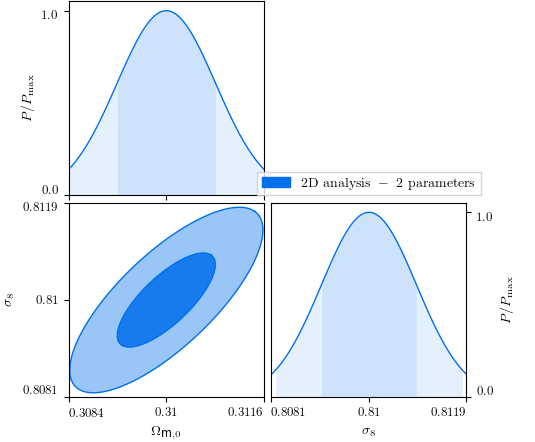

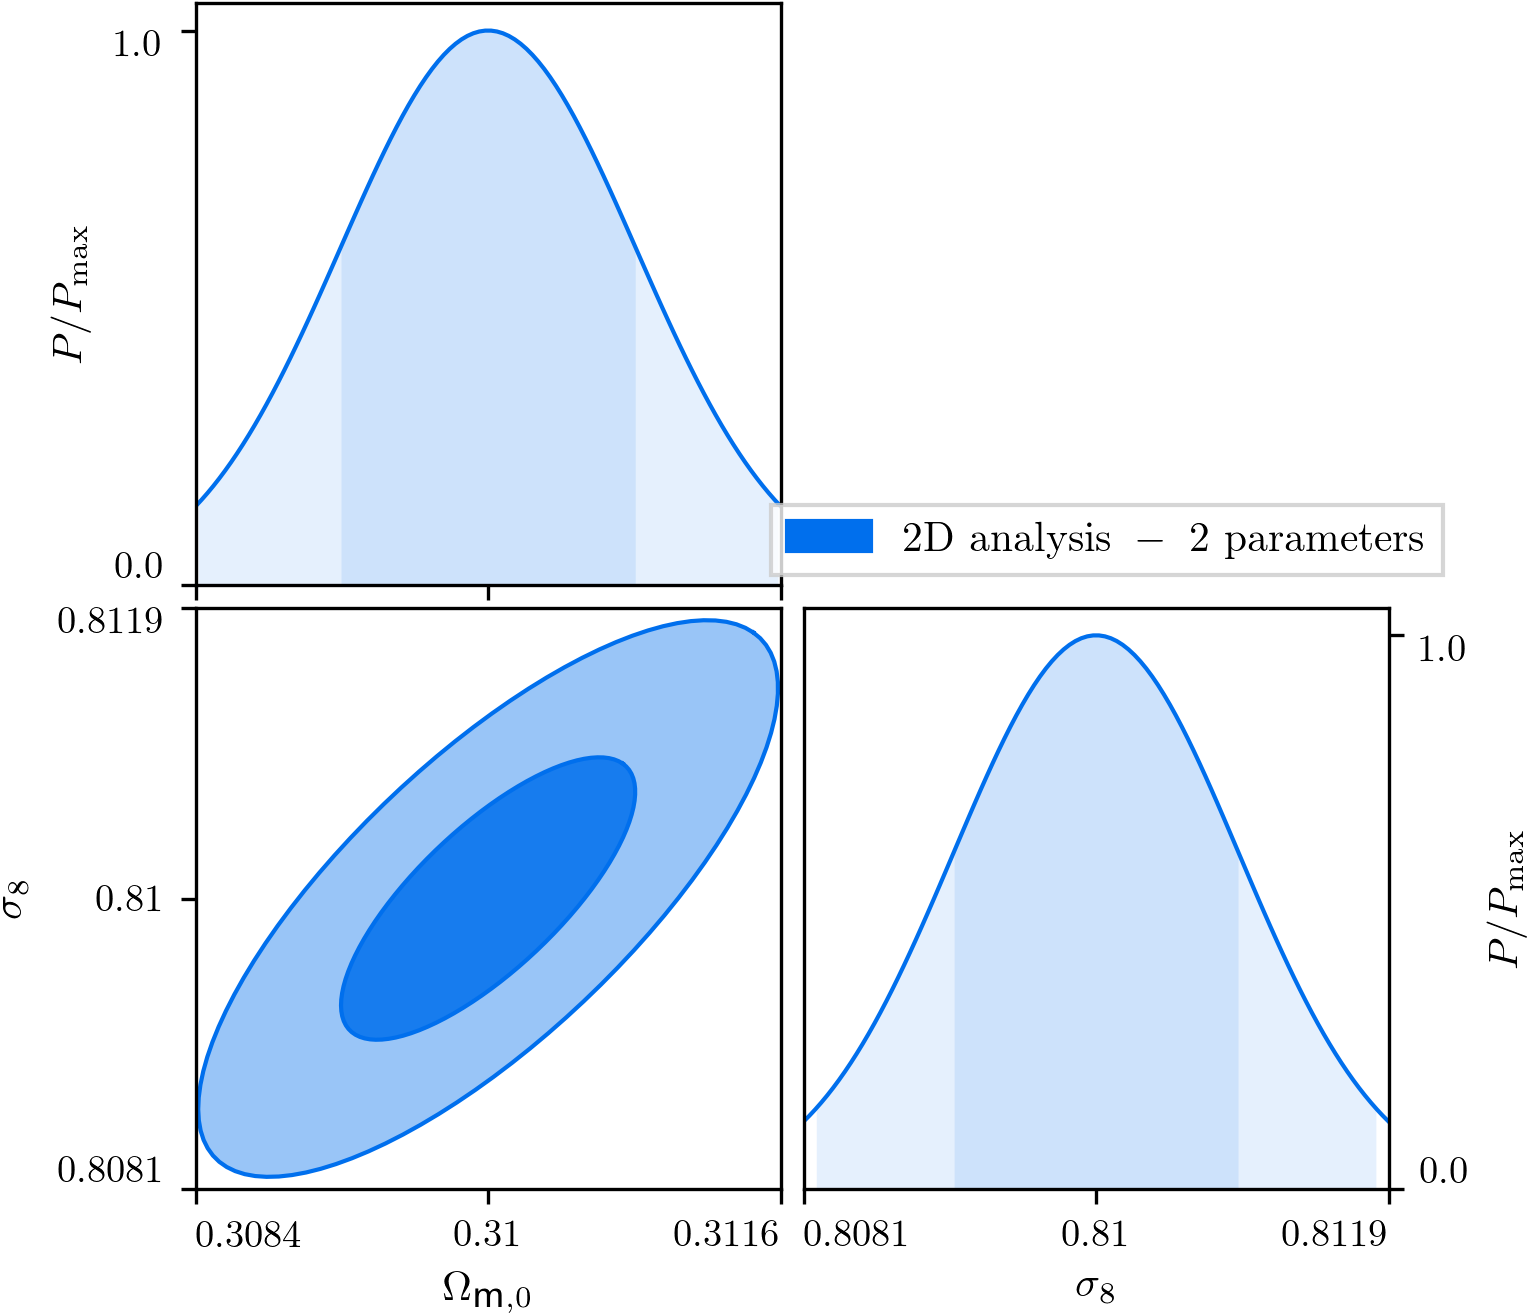

In [29]:
fisher_plotter.new_plot()
fisher_plotter.plot_tri()
fisher_plotter.export('2D_clust.pdf', dpi=100)
fisher_plotter.export('2D_clust.png', dpi=100)
IPython.display.Image(filename='2D_clust.png',unconfined=True)

In [30]:
print(Fisher)

[[ 3559862.46999676 -2347090.83043113]
 [-2347090.83043113  2710137.13778511]]
